In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!git clone https://github.com/Mahsarnzh/XAI_Nuc.git 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'XAI_Nuc'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 158 (delta 32), reused 26 (delta 9), pack-reused 79
Receiving objects: 100% (158/158), 5.35 MiB | 6.62 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.5 MB/s eta 0:00:00


In [3]:
import sys
import os
sys.path.append("/content/XAI_Nuc/")

In [4]:
import shap

In [5]:
%cd /content/XAI_Nuc

/content/XAI_Nuc


In [6]:
import criticNet.model
import actorNet.model

In [7]:
import criticNet_env.model
import actorNet_env.model

In [8]:
model_actorNet = actorNet.load_model(os.path.join(os.path.dirname(actorNet.__file__), "weights.h5"))
model_criticNet = criticNet.load_model(os.path.join(os.path.dirname(criticNet.__file__), "weights.h5"))

In [9]:
model_actorNet_env = actorNet_env.load_model(os.path.join(os.path.dirname(actorNet_env.__file__), "weights.h5"))
model_criticNet_env = criticNet_env.load_model(os.path.join(os.path.dirname(criticNet_env.__file__), "weights.h5"))

In [10]:
! pip install onnx_tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 31.1 MB/s eta 0:00:00


In [11]:
import onnx
from onnx_tf.backend import prepare



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 



In [12]:
import onnx

from onnx_tf.backend import prepare

actorNet_onnx_model = onnx.load("actorNet.onnx")  # load onnx model
tf_rep = prepare(actorNet_onnx_model)  # prepare tf representation
tf_rep.export_graph("output_path")  

In [13]:
import tensorflow as tf
import numpy as np

# Load the ONNX model
actorNet_onnx = onnx.load("actorNet.onnx")

# Prepare the ONNX model for TensorFlow
actorNet_onnx_model = prepare(actorNet_onnx)

In [14]:
actorNet_onnx_model

In [15]:
import numpy as np
import gym
from gym import spaces
import itertools
from gym.spaces import Box

class Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A(gym.Env):
    def __init__(self):
        self.NumComponents = 1
        self.MaxTime = 200
        self.RefuelPeriod = 18
        self.MaxInitialHealth = 0.9999
        self.MinInitialHealth = 0.8
        self.InitialHealthNoise = 0.01
        self.MinHealth = 0
        self.DegradationMean = 0.05
        self.DegradationVar = 0.1
        self.SensorNoiseVar = 0
        self.LeadTime = 5
        self.PenaltyForThirdCapacity = -40
        self.PenaltyForHalfCapacity = -60
        self.PenaltyForNotOperating = -100
        self.CostToRepair = -10
        self.CostToReplace = -5
        self.CostToOrder = -15
        self.CostInventory = -1
        
        self.ObservationInfo = spaces.Box(low=-np.inf, high=np.inf, shape=(5, 1), dtype=np.float32)

        elements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])

        ActionInfo = elements.tolist()
        self.ActionInfo = ActionInfo

        # self.State = np.zeros((5, 1))
        self.IsDone = 0
        
    def step(self, action):
        MaintDecision1 = action[0]
        OrderPart1 = action[1]
        # print(OrderPart1, MaintDecision1)

        Month = self.State[0]
        Component1 = self.State[1]
        Inv1 = self.State[2]
        ArrivalDate1 = self.State[3]
        PartReplaced1 = self.State[4]
        
        Month += 1
        PartReplaced1 = 0
        # print(Inv1, MaintDecision1)

        if MaintDecision1 == 2 and Inv1 > 0:  # Replace
            Inv1 -= 1
            Component1 = self.MaxInitialHealth - np.random.gamma(self.InitialHealthNoise)
            PartReplaced1 = 1
            

            if Component1 < self.MinInitialHealth:
                Component1 = self.MinInitialHealth
                # print(Component1)

        elif MaintDecision1 == 1:  # Repair
            Component1 += (self.MaxInitialHealth - Component1) * 0.1  # about 10 percent increase in health gap
            # print(Component1)



        if Month % self.RefuelPeriod != 0:
            Component1 -= np.abs(self.DegradationMean + self.DegradationVar * np.random.randn()) * (1 - Component1)
        
        # Component1 = max(Component1, 0)  # Health can not be less than 0
        
        if Component1 == 0:
            Sensor1 = 0  # self-announcing failure
        else:
            Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
            if Sensor1 > 1:
              Sensor1 = min(Sensor1, 1)
            elif Sensor1 < 0:
              Sensor1 = max(Sensor1,-0.11)
            Sensor1 = max(min(Sensor1, 1), -0.11)
        
        if Month % self.RefuelPeriod == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - Month % self.RefuelPeriod) / self.RefuelPeriod
        
        # data = np.array(ArrivalDate1)
        # updated_data = np.array([data[0][0] - 1])
                  # ArrivalDate1 -= 1
        
        ArrivalDate1 = [x - 1 for x in ArrivalDate1];
        if len(ArrivalDate1) > 0:
            if ArrivalDate1[0] == 0:
                Inv1 += 1  # Add part to inventory
                ArrivalDate1 = [x for x in ArrivalDate1 if x > 0]  # Remove countdown from backlog



        if OrderPart1:
            ArrivalDate1 = np.append(ArrivalDate1, self.LeadTime)
        
        if len(ArrivalDate1) > 0:
            OnOrder1 = ArrivalDate1[0] / self.LeadTime
        else:
            OnOrder1 = 0
        
        InvNorm1 = Inv1 / 200
        InvFlag1 = int(np.any(Inv1 > 0))
        
        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1] , dtype=object)
        # self.State = tf.convert_to_tensor(State, dtype=object)

        observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        # observation = tf.reshape(Observation, (1, -1))    

        
        self.IsDone = 0
        reward = self.get_reward(self.State, action)
        return observation, reward, self.IsDone, {}
    
    def reset(self):
        Component1 = self.MaxInitialHealth - 0.05 * np.random.rand()
        Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
        Sensor1 = max(min(Sensor1, 1), 0)
        Inv1 = 0
        InvNorm1 = Inv1 / 200
        InvFlag1 = int(Inv1 > 0)
        ArrivalDate1 = []
        OnOrder1 = 0
        PartReplaced1 = 0
        Month = 1
        
        if Month % self.RefuelPeriod == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - Month % self.RefuelPeriod) / self.RefuelPeriod

        # Sensor1 = -0.6
        # DaysToShutdown = -30
        # InvNorm1 = 1.5

        initial_observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        initial_observation = tf.ragged.constant(initial_observation)

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1], dtype=object)
        # print(Sensor1)
        # self.State = tf.convert_to_tensor(State, dtype=tf.float32)
        return initial_observation
    
    def get_reward(self, State, Action):
        Month = State[0]
        Sensor1 = State[1]
        Inv1 = State[2]
        PartReplaced1 = State[4]
        
        Action1 = Action[0]
        OrderPart1 = Action[1]
        
        reward = 0
        
        if Inv1 > 0:
            reward += self.CostInventory * Inv1
        
        reward += self.CostToOrder * OrderPart1
        
        if Sensor1 == 0 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity
        elif PartReplaced1 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity
        
        if Action1 == 1:
            reward += self.CostToRepair
        elif PartReplaced1:
            reward += self.CostToReplace
        
        return reward


In [16]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

env = Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A()

discount_factor = 0.999
max_steps_per_episode = 720

# Define the optimization algorithms for actor and critic networks
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


actorNet_onnx = onnx.load("actorNet.onnx")

# Prepare the ONNX model for TensorFlow
# actorNet_onnx_model = prepare(actorNet_onnx)



actor = model_actorNet_env
critic = model_criticNet_env
state_tensors = []
episode_rewards = []
actionss = []
num_episodes = 1
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    # with tf.GradientTape(persistent=True) as tape:
    for t in range(max_steps_per_episode):

        state_tensor = tf.convert_to_tensor(state)
        state_tensor_ = tf.expand_dims(state_tensor, 0)
        
        input_data = tf.cast(state_tensor_, dtype=tf.float32)
        # Create input tensor
        input_data = tf.constant(input_data, dtype=tf.float32) 
        state_tensors.append(input_data) 

        # state_tensors.append(state_tensor_) 

        # Get action probabilities from actor network
        action_probs = actorNet_onnx_model.run(input_data)

        # action_probs = actor(state_tensor_)

        # Sample an action from the action probabilities
        action_log_prob = tf.argmax(action_probs, axis=-1)
        action_index = action_log_prob.numpy().item()

        # action_log_prob = torch.argmax(action_logits)
        actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])


        # Retrieve the corresponding action

        action = actionelements[action_index]

        actionss.append(action)

        # Take the action in the environment
        state, reward, done, _ = env.step(action)
   
        episode_reward += reward
        episode_rewards.append(episode_reward)  # Save state_tensor to the list

        if done:
            break
        

    # print("Episode {}: Reward = {}".format(episode, episode_reward))
    state_log_ = tf.squeeze(state_tensors)
    action_log_ = tf.squeeze(actionss)
    state_log_ = np.array(state_log_)
    action_log_ = np.array(action_log_)

    # rewards = tf.squeeze(episode_rewards)
    state_log = np.array(state_tensors)
    action_log = np.array(actionss)

    t_values = np.arange(num_episodes)  # Generate an array of indices from 0 to max_steps_per_episode
# self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1], dtype=object)


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


<Figure size 640x480 with 0 Axes>

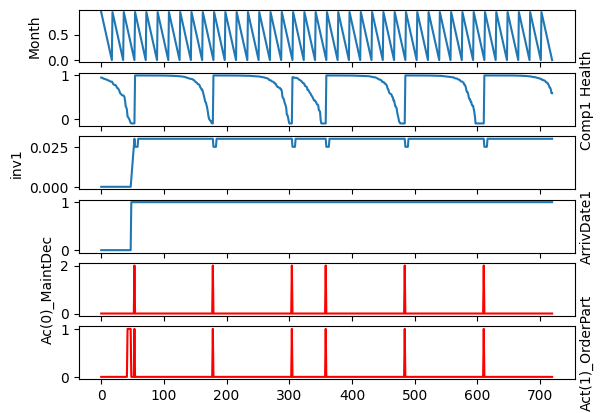

In [17]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0,0]), plt.ylabel('Month')
# plt.subplot(611), plt.plot(state_log[0]), plt.ylabel('Month')

plt.subplot(612), plt.plot(state_log[:,0,1]), plt.ylabel('Comp1 Health')
plt.subplot(612).yaxis.set_label_position('right')

plt.subplot(613), plt.plot(state_log[:,0,2]), plt.ylabel('inv1')

plt.subplot(614), plt.plot(state_log[:,0,3]), plt.ylabel('ArrivDate1')
plt.subplot(614).yaxis.set_label_position('right')

# plt.subplot(615), plt.plot(state_log[:,0,4]), plt.ylabel('fPartReplaced1')
# plt.subplot(615), plt.plot(actionss, 'r'), plt.ylabel('Ac(0)_MaintDec')
plt.subplot(615), plt.plot(action_log[:,0], 'r'), plt.ylabel('Ac(0)_MaintDec')


plt.subplot(616), plt.plot(action_log[:,1], 'r'), plt.ylabel('Act(1)_OrderPart')
plt.subplot(616).yaxis.set_label_position('right')



In [18]:
def model_predict(data):
    inputs = {actorNet_onnx_model.inputs[0]: data}
    outputs = actorNet_onnx_model.run(inputs)
    return outputs[0]

In [19]:
def model_predict_Max(data):
    inputs = {actorNet_onnx_model.inputs[0]: data}
    outputs = actorNet_onnx_model.run(inputs)
    max_values = np.max(outputs[0], axis=-1)
    return max_values


In [20]:
# Define the names of the states
feature_names=['Month', 'Component1', 'Inv1', 'ArrivalDate1', 'fPartReplaced1']

In [21]:
state_log_reshaped = state_log.reshape(state_log.shape[0], -1)
explainer__Max = shap.KernelExplainer(model_predict_Max, state_log_reshaped)
shap_values__Max = explainer__Max.shap_values(state_log_reshaped)

  0%|          | 0/720 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


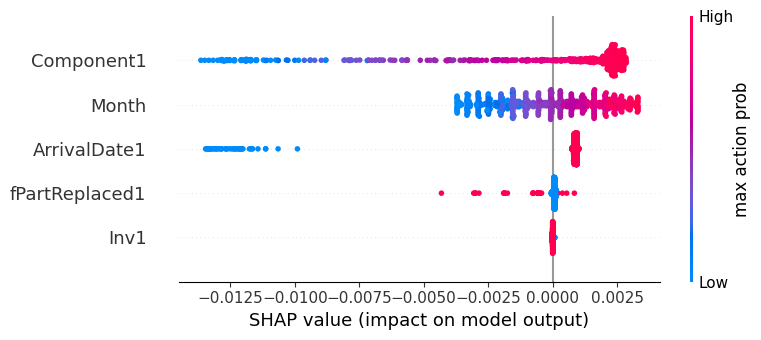

In [22]:
shap.summary_plot(shap_values__Max, state_log_reshaped, feature_names=feature_names, color_bar_label = 'max action prob')

In [23]:
state_log_reshaped = state_log.reshape(state_log.shape[0], -1)
explainer = shap.KernelExplainer(model_predict, state_log_reshaped)
shap_values = explainer.shap_values(state_log_reshaped)

  0%|          | 0/720 [00:00<?, ?it/s]

In [24]:
shap_values_ = np.array(shap_values)
model_predict_np = np.array(model_predict(state_log_reshaped))
print(shap_values_.shape)
print(model_predict_np.shape)

(6, 720, 5)
(720, 6)


In [25]:
shap_values_ = np.array(shap_values)
model_predict_np = np.array(model_predict(state_log_reshaped))
print(shap_values_.shape[0])
print(model_predict_np.shape)

6
(720, 6)


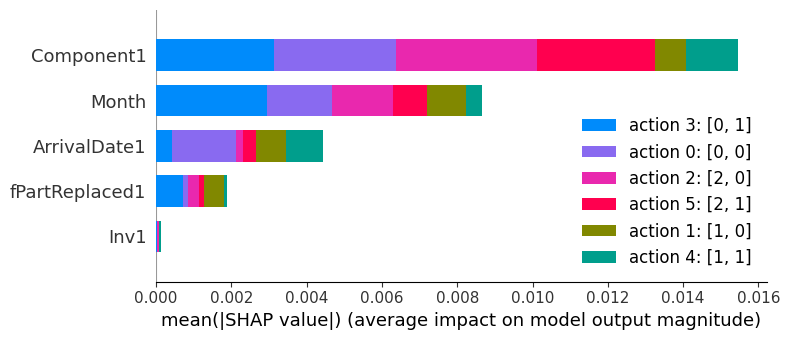

In [26]:
class_names = ["action 0: [0, 0]", "action 1: [1, 0]", "action 2: [2, 0]", "action 3: [0, 1]", "action 4: [1, 1]", "action 5: [2, 1]"]
shap.summary_plot(shap_values, feature_names=feature_names, class_names=class_names)
# shap.summary_plot(shap_values, feature_names=feature_names)

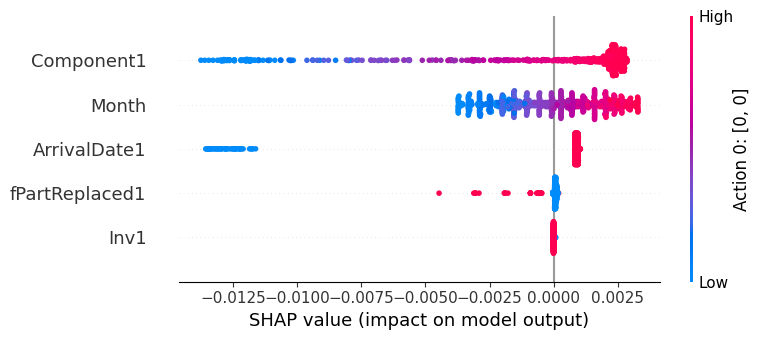

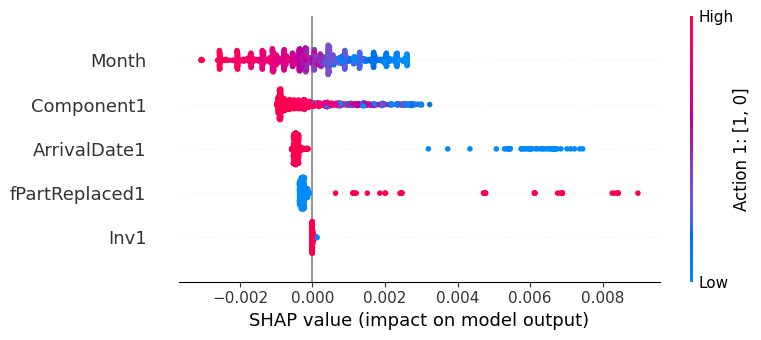

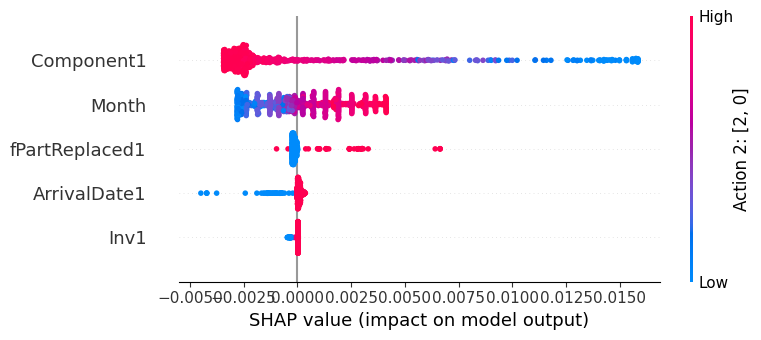

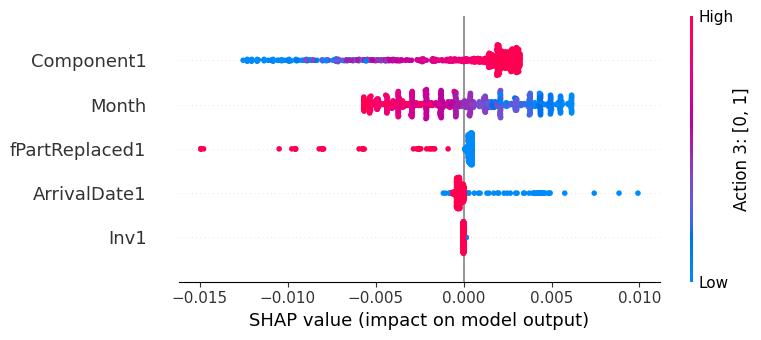

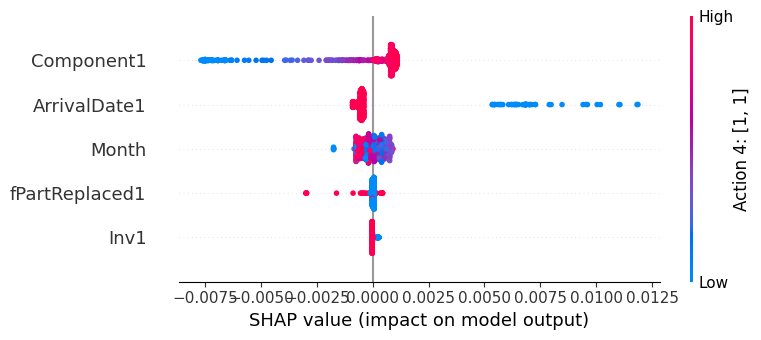

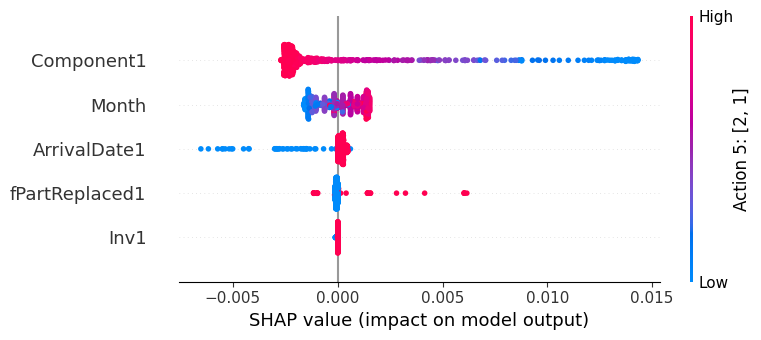

In [27]:
class_names = ["Action 0: [0, 0]", "Action 1: [1, 0]", "Action 2: [2, 0]", "Action 3: [0, 1]", "Action 4: [1, 1]", "Action 5: [2, 1]"]

shap_values_ = np.array(shap_values)
for i in range(shap_values_.shape[0]):
# for i in range(6):

  shap.summary_plot(shap_values[i], state_log_reshaped,  feature_names=feature_names, color_bar_label='{}'.format(class_names[i]))
  
 

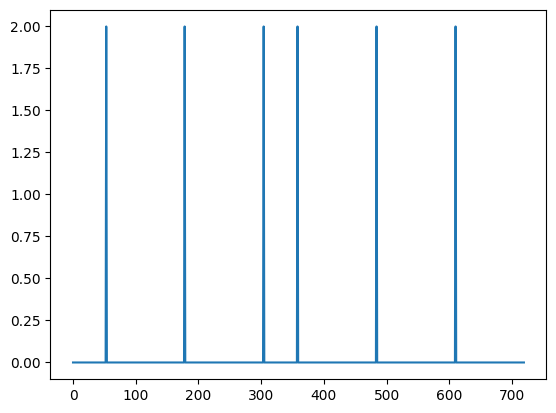

In [28]:
plt.plot(action_log[:,0])


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


(<Axes: ylabel='Observations'>,
 Text(0, 0.5, 'Observations'))

<Figure size 640x480 with 0 Axes>

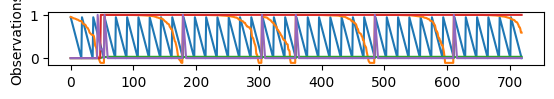

In [29]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0]), plt.ylabel('Observations')

In [30]:
def explain(actorNet_onnx_model_ = actorNet_onnx_model.run, state_log_=state_log, feature_names=feature_names, action_log_=action_log, cmap='coolwarm', save_fig=False):

    # Build explainer
    # model = ([observation], action) # define inputs and outputs of actor
    
    explainer = shap.KernelExplainer(actorNet_onnx_model_, state_log)
    shap_values = explainer.shap_values(state_log) # Calculate shap values
       
    state_log_re = state_log # rescale state log 
    
    norm = plt.Normalize(vmin=0, vmax=2) # define color scala between -1 and +1 (like the agents action space)  
        
    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(len(action_log)), action_log[:,0], c=action_log[:,0] - explainer.expected_value[0], cmap=cmap, norm=norm)
    axs[0].scatter(range(len(action_log)), action_log[:,1], c=action_log[:,1] - explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action')
    axs[1].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])   
    axs[1].yaxis.set_label_position('right')
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[3].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[4].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[5].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])   
    axs[5].yaxis.set_label_position('right')   


    
    if save_fig:
        fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')

    

In [31]:
def explain(actor = model_actorNet, critic = model_criticNet, state_log_=state_log_, feature_names=feature_names, action_log_=action_log_, cmap='coolwarm', save_fig=False):

    # Build explainer
    # model = ([observation], action) # define inputs and outputs of actor
    
    explainer = shap.KernelExplainer(model_actorNet, state_log_)
    shap_values = explainer.shap_values(state_log_) # Calculate shap values
       
    state_log_re = state_log_ # rescale state log 
    
    norm = plt.Normalize(vmin=0, vmax=2) # define color scala between -1 and +1 (like the agents action space)  
        
    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(len(action_log)), action_log[:,0], c=action_log[:,0] - explainer.expected_value[0], cmap=cmap, norm=norm)
    axs[0].scatter(range(len(action_log)), action_log[:,1], c=action_log[:,1] - explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action')
    axs[1].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])   
    axs[1].yaxis.set_label_position('right')
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[3].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[4].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[5].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])   
    axs[5].yaxis.set_label_position('right')   


    
    if save_fig:
        fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')

    

  0%|          | 0/720 [00:00<?, ?it/s]

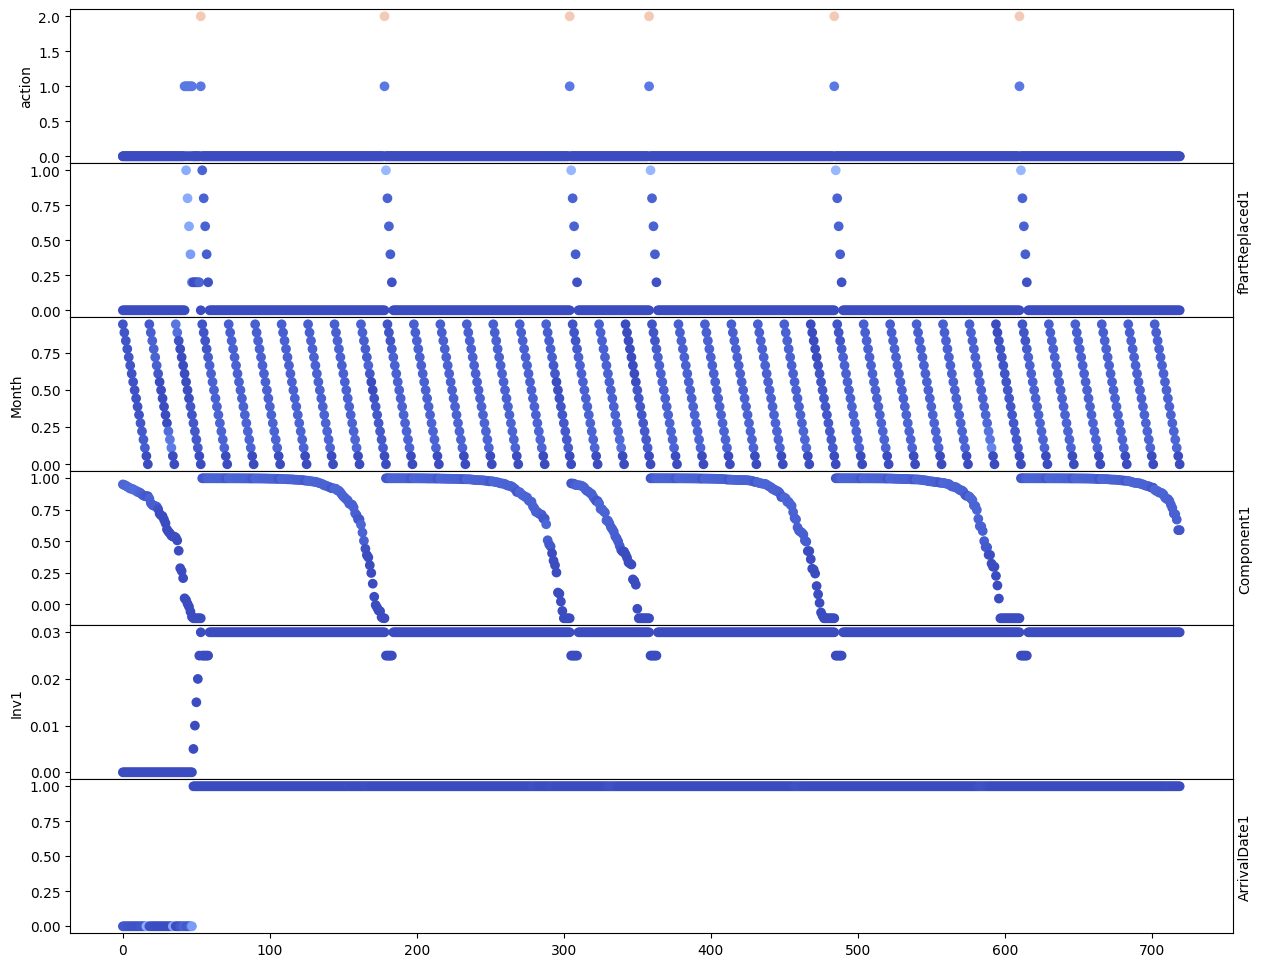

In [32]:
import matplotlib.pyplot as plt

# output with shap values
explain(model_actorNet, model_criticNet, state_log_, feature_names, action_log_)

In [33]:
explainer = shap.KernelExplainer(model_actorNet, state_log_)
shap_values = explainer.shap_values(state_log_) # Calculate shap values

  0%|          | 0/720 [00:00<?, ?it/s]

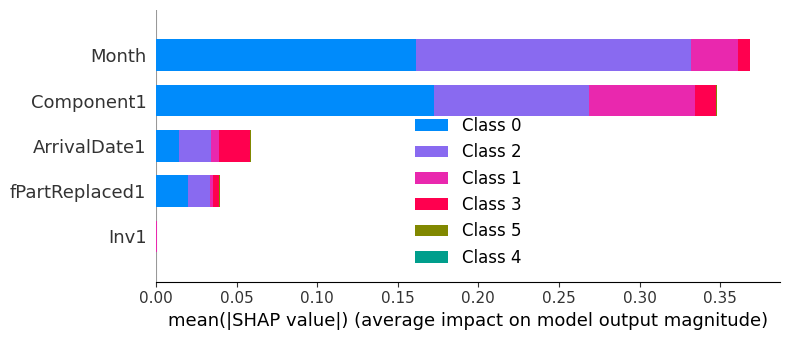

In [34]:
shap.summary_plot(shap_values, feature_names=feature_names)

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


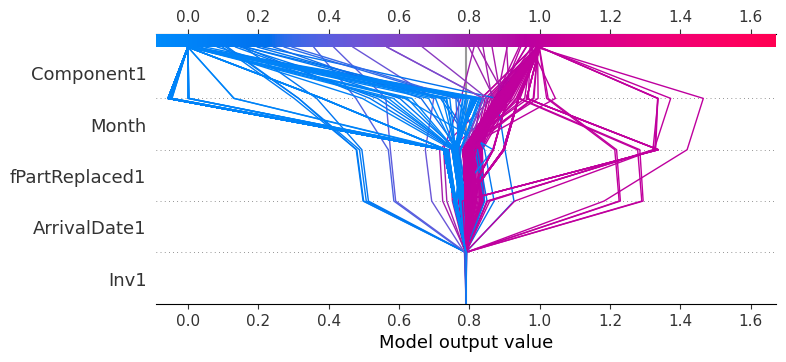

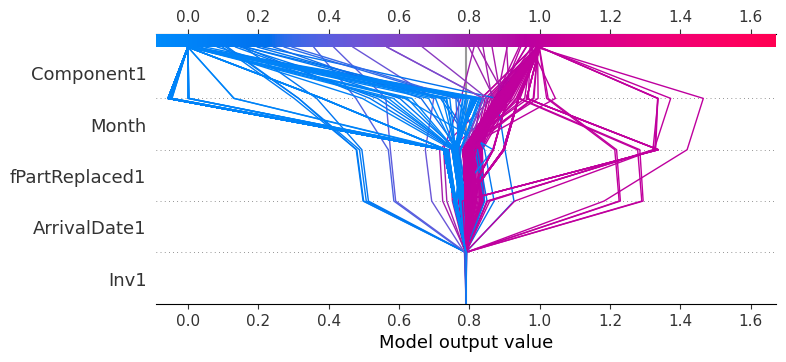

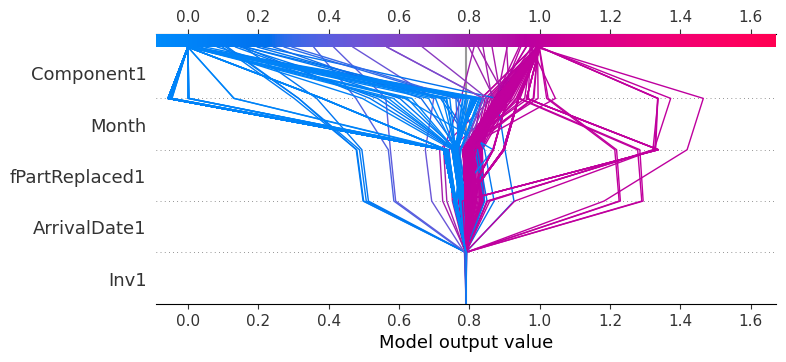

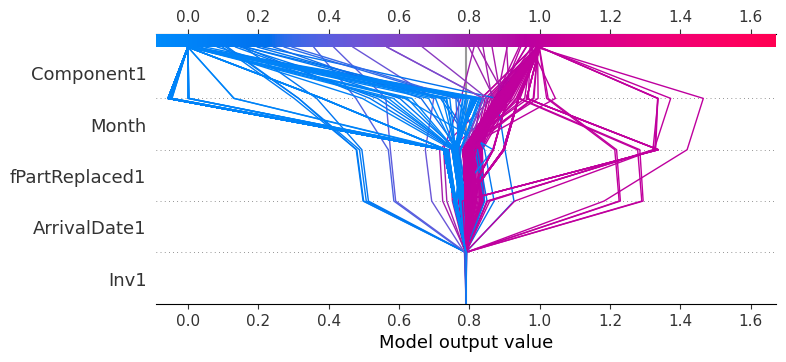

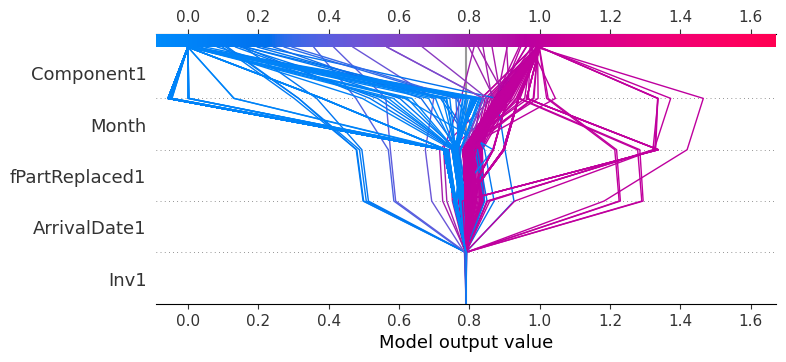

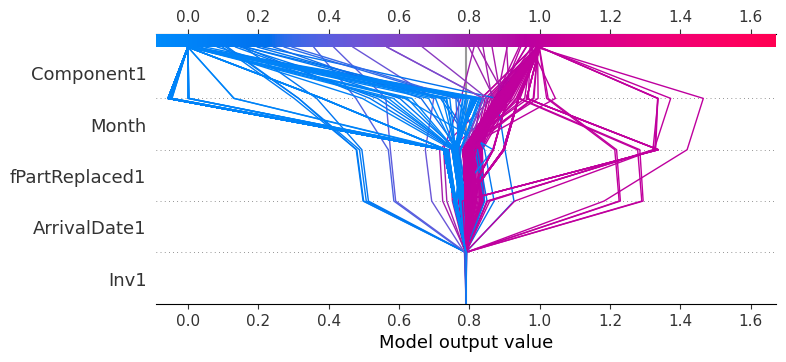

In [35]:
for i in range(len(shap_values)):
  shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names)


In [36]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [38]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [39]:
shap.initjs()
shap.force_plot(explainer.expected_value[4], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [40]:
shap_values_ = np.array(shap_values)
print(shap_values_.shape)
shap_values_ = np.array(shap_values[1])
print(shap_values_.shape)


(6, 720, 5)
(720, 5)


In [41]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [42]:
explainer = shap.KernelExplainer(model_criticNet, state_log_)
shap_values = explainer.shap_values(state_log_) # Calculate shap values

  0%|          | 0/720 [00:00<?, ?it/s]

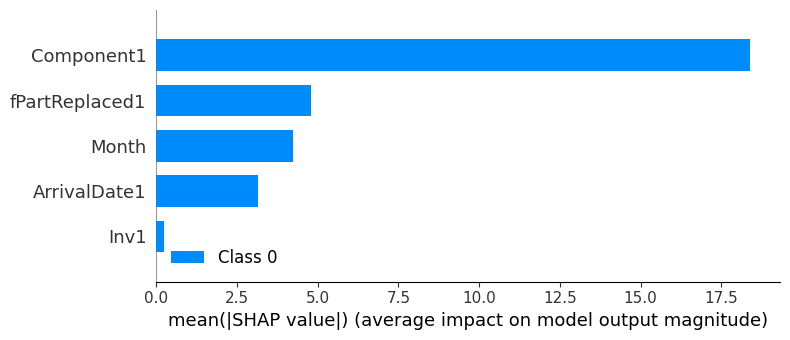

In [43]:
shap.summary_plot(shap_values, feature_names=feature_names)

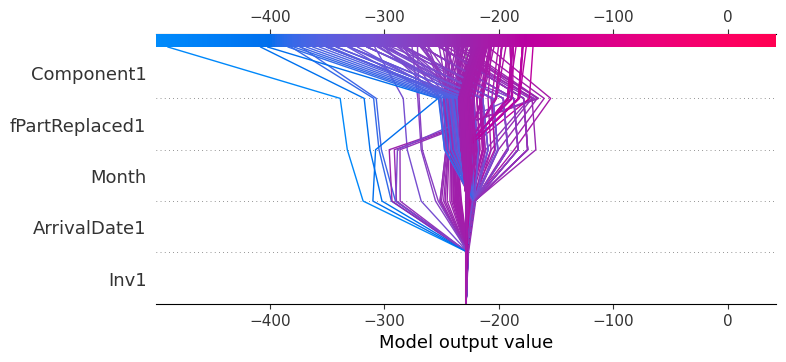

In [44]:
shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names)


